# 1) Identify Hough Lines

In [1]:
import cv2
import numpy as np
from IPython.display import Image

In [2]:
import glob
glob.glob("../../Images/*")

['../../Images\\1.png',
 '../../Images\\2.png',
 '../../Images\\3.png',
 '../../Images\\4.png',
 '../../Images\\5.png',
 '../../Images\\datasheet_sample.png',
 '../../Images\\sudoku-original.jpg',
 '../../Images\\test.jpg']

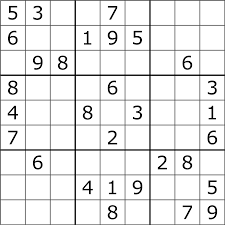

In [82]:
file_path = '../../Images/1.png'
Image(file_path)

Preprocess the input image at the specified file path. First step is to perform a color conversion on the image to transform the image to grayscale. Next step is to detect edges using the popular Canny algorithm created by John F. Canny (read more [here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html)). Dilate the edges of the image and then erode the thick boarders produced after dialation. Create a staging image and display the results.

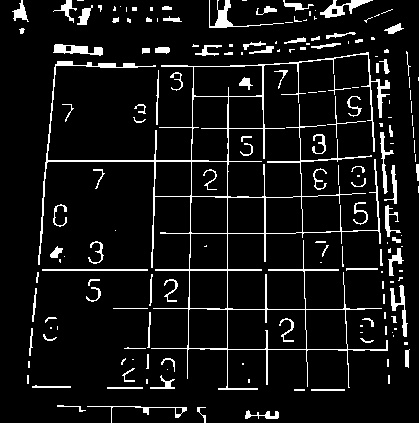

In [80]:
apply_filter = False

# img = cv2.imread(file_path)
# gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# edges = cv2.Canny(gray,50,150,apertureSize = 3)
# minLineLength = 1000
# maxLineGap = 10
# lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
# for x1,y1,x2,y2 in lines[0]:
#     cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

# cv2.imwrite('houghlines5.jpg',img)
# Image('houghlines5.jpg')

# img = cv2.imread(file_path)
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# blur = cv2.medianBlur(gray, 5)
# adapt_type = cv2.ADAPTIVE_THRESH_GAUSSIAN_C
# thresh_type = cv2.THRESH_BINARY_INV
# bin_img = cv2.adaptiveThreshold(blur, 255, adapt_type, thresh_type, 11, 2)
# cv2.imwrite('binary.jpg',bin_img)
# Image('binary.jpg')

img = cv2.imread(file_path)

# Preprocess the input image 
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,90,150,apertureSize = 3)
kernel = np.ones((3,3),np.uint8)
edges = cv2.dilate(edges,kernel,iterations = 1)
kernel = np.ones((5,5),np.uint8)
edges = cv2.erode(edges,kernel,iterations = 1)
cv2.imwrite('canny.jpg',edges)

# Display image (only supported in ipynb)
Image('canny.jpg')

Detect the lines using Hough Transform

In [30]:
lines = cv2.HoughLines(edges,1,np.pi/180,150)
    
if not lines.any():
    print('No lines were found')
else:
    if apply_filter:
        rho_threshold = 15
        theta_threshold = 0.1

        # how many lines are similar to a given one
        similar_lines = {i : [] for i in range(len(lines))}
        for i in range(len(lines)):
            for j in range(len(lines)):
                if i == j:
                    continue

                rho_i,theta_i = lines[i][0]
                rho_j,theta_j = lines[j][0]
                if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                    similar_lines[i].append(j)

        # ordering the INDECES of the lines by how many are similar to them
        indices = [i for i in range(len(lines))]
        indices.sort(key=lambda x : len(similar_lines[x]))

        # line flags is the base for the filtering
        line_flags = len(lines)*[True]
        for i in range(len(lines) - 1):
            if not line_flags[indices[i]]: # if we already disregarded the ith element in the ordered list then we don't care (we will not delete anything based on it and we will never reconsider using this line again)
                continue

            for j in range(i + 1, len(lines)): # we are only considering those elements that had less similar line
                if not line_flags[indices[j]]: # and only if we have not disregarded them already
                    continue

                rho_i,theta_i = lines[indices[i]][0]
                rho_j,theta_j = lines[indices[j]][0]
                if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                    line_flags[indices[j]] = False # if it is similar and have not been disregarded yet then drop it now

    print('number of Hough lines:', len(lines))

number of Hough lines: 77


Apply filter as needed (default false)

In [31]:
filtered_lines = []
print("Apply Filter: {}".format(apply_filter))
if apply_filter:
    for i in range(len(lines)): # filtering
        if line_flags[i]:
            filtered_lines.append(lines[i])

    print('Number of filtered lines:', len(filtered_lines))
else:
    filtered_lines = lines

Apply Filter: False


Draw the Hough lines on the original image and display the image

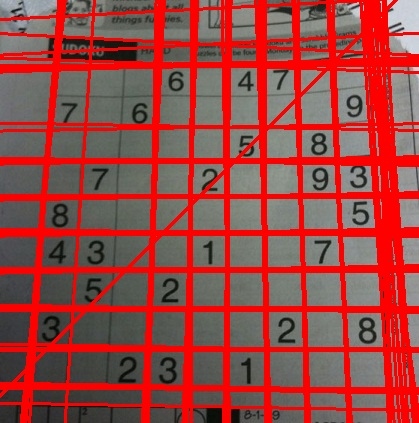

In [32]:
for line in filtered_lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

cv2.imwrite('hough.jpg',img)
Image('hough.jpg')

# 2) Identify Hough Intersections

Now, if we want to find the intersections, really we want to find the intersections only of the perpendicular lines. We don't want the intersections of mostly parallel lines. So we need to segment our lines. In this particular example you could easily just check whether the line is horizontal or vertical based on a simple test; the vertical lines will have a ```theta``` of around 0 or around 180; the horizontal lines will have a ```theta``` of around 90. However, if you want to segment them based on an arbitrary number of angles, automatically, without you defining those angles, I think the best idea is to use ```cv2.kmeans()```.

There is one tricky thing to get right. ```HoughLines``` returns lines in ```rho, theta``` form ([Hesse normal form](https://en.wikipedia.org/wiki/Hesse_normal_form)), and the ```theta``` returned is between 0 and 180 degrees, and lines around 180 and 0 degrees are similar (they are both close to horizontal lines), so we need some way to get this periodicity in ```kmeans```.

If we plot the angle on the unit circle, but multiply the angle by two, then the angles originally around 180 degrees will become close to 360 degrees and thus will have ```x, y``` values on the unit circle near the same for angles at 0. So we can get some nice "closeness" here by plotting 2*angle with the coordinates on the unit circle. Then we can run ```cv2.kmeans()``` on those points, and segment automatically with however many pieces we want.

So let's build a function to do the segmentation:

In [23]:
from collections import defaultdict
def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """Groups lines based on angle with k-means.

    Uses k-means on the coordinates of the angle on the unit circle 
    to segment `k` angles inside `lines`.
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # returns angles in [0, pi] in radians
    angles = np.array([line[0][1] for line in lines])
    # multiply the angles by two and find coordinates of that angle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)]
                    for angle in angles], dtype=np.float32)

    # run kmeans on the coords
    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    for i, line in zip(range(len(lines)), lines):
        segmented[labels[i]].append(line)
    segmented = list(segmented.values())
    return segmented

In [24]:
# Create a 2D array denoting the two segmented groups (e.g., horizontal and vertical lines)
segmented = segment_by_angle_kmeans(filtered_lines)

In [25]:
print("Groups: {}".format(len(segmented)))

Groups: 2


What's nice is here we can specify an arbitrary number of groups by specifying the optional argument ```k``` (by default, ```k = 2``` so I didn't specify it here).

If we plot the lines from each group with a different color:

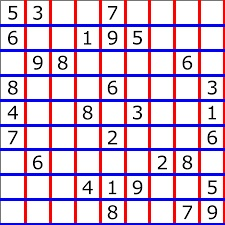

In [26]:
group1_color = (0,0,255)
group2_color = (255,0,0)

line_group1 = segmented[0]
line_group2 = segmented[1]

for line in line_group1:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img,(x1,y1),(x2,y2),group1_color,2)
    
for line in line_group2:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img,(x1,y1),(x2,y2),group2_color,2)
    
cv2.imwrite('hough_grouped.jpg',img)
Image('hough_grouped.jpg')

And now all that's left is to find the intersections of each line in the first group with the intersection of each line in the second group. Since the lines are in Hesse normal form, there's a nice linear algebra formula for calculating the intersection of lines from this form. See [here](https://stackoverflow.com/questions/383480/intersection-of-two-lines-defined-in-rho-theta-parameterization). Let's create two functions here; one that finds the intersection of just two lines, and one function that loops through all the lines in the groups and uses that simpler function for two lines:

In [27]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]

In [28]:
def segmented_intersections(lines):
    """Finds the intersections between groups of lines."""

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 

    return intersections

In [29]:
# Get the list of Hough intersections
intersections = segmented_intersections(segmented)

In [30]:
print("Hough Intersections Identified: {}".format(len(intersections)))

Hough Intersections Identified: 81


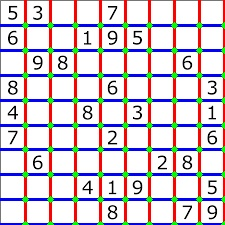

In [31]:
# Plot the Hough intersections
for intersection in intersections:
    point = tuple(intersection[0])
    cv2.line(img,point,point,(0, 255, 0),5)

cv2.imwrite('hough_intersections.jpg',img)
Image('hough_intersections.jpg')

# 3) Extract Images Between Hough Intersections

The next step is not necessarily trivial. We need to determine the width and height of each square we want to extract a number from. To do this, we need to iterate the list of Hough intersections we calculated previously and determine the distance between the current intersection to the next intersection below (for height) and to the right (for width). In downloaded images where there is no noise and the image is not tilted, it would be reasonable to assume that we could take the average widths and heights and then start from the top of the image and iterate through the image to extract subimages using the widths and heights (e.g., like a tilemap). Unfortunately, this will not always be the case and the image can be tilted, making the use of an average width and height unfit for a solution.

Fortunately, we can determine the exact width and height per case as we are iterating through the list of intersection points. We will have to use a data structure to store the widths and heights so they can be looked up when we are ready to perform the actual extraction processes.

In [52]:
from PIL import Image
import IPython.display as display

# Load the original image
original_image = Image.open(file_path)
print("Image Width: {}".format(original_image.width))
print("Image Height: {}".format(original_image.height))

# Get a croped portion of the original image
crop_rectangle = (25, 25, 50, 50)
cropped_im = original_image.crop(crop_rectangle)

cropped_im.save('crop_example.png')
display.Image('crop_example.png')

Image Width: 225
Image Height: 225


In [56]:
# Create staging dir if it does not exist
import os
if not os.path.exists('staging'):
    os.makedirs('staging')
    
cell_width = 25
cell_height = 25
# Iterate intersections (Note: the hough intersections are stored in vertical order rather than horizontal)
for i in range(len(intersections)):
    point = tuple(intersections[i][0])
    print("Current point: {}".format(point))
    
    # Determine height by finding next adjacent vertical hough intersection point
    if (i + 1) < len(intersections):
        next_point = tuple(intersections[i + 1][0])
        print("Next point: {}".format(next_point))
        print("Difference X: {}".format(next_point[0] - point[0]))
        print("Difference Y: {}".format(next_point[1] - point[1]))
    else:
        print("No next point")
    
#     leftX = point[0]
#     upperY = point[1]
#     rightX = point[0] + cell_width
#     lowerY = point[1] + cell_height
    
    # Create the cropped rectangle (imagine dragging mouse from top left to bottom right for cropping)
#     crop_rectangle = (leftX, upperY, rightX, lowerY)
#     print (crop_rectangle)
#     cropped_im = original_image.crop(crop_rectangle)
#     cropped_im.save('staging/cell{}.png'.format(i+1))


Current point: (25, 25)
Next point: (25, 50)
Difference X: 0
Difference Y: 25
Current point: (25, 50)
Next point: (25, 75)
Difference X: 0
Difference Y: 25
Current point: (25, 75)
Next point: (25, 100)
Difference X: 0
Difference Y: 25
Current point: (25, 100)
Next point: (25, 125)
Difference X: 0
Difference Y: 25
Current point: (25, 125)
Next point: (25, 149)
Difference X: 0
Difference Y: 24
Current point: (25, 149)
Next point: (25, 174)
Difference X: 0
Difference Y: 25
Current point: (25, 174)
Next point: (25, 199)
Difference X: 0
Difference Y: 25
Current point: (25, 199)
Next point: (25, 224)
Difference X: 0
Difference Y: 25
Current point: (25, 224)
Next point: (50, 25)
Difference X: 25
Difference Y: -199
Current point: (50, 25)
Next point: (50, 50)
Difference X: 0
Difference Y: 25
Current point: (50, 50)
Next point: (50, 75)
Difference X: 0
Difference Y: 25
Current point: (50, 75)
Next point: (50, 100)
Difference X: 0
Difference Y: 25
Current point: (50, 100)
Next point: (50, 125)
D